In [1]:
# Importing dependencies
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import random
from matplotlib.animation import FuncAnimation

def generate_plot(graph):
    fig, ax = ox.plot_graph(graph, node_color='blue', edge_linewidth=2, bgcolor='white', show=False)

    # Add label with road length (m)
    for u, v, key, data in graph.edges(keys=True, data=True):
        if 'length' in data:
            # Compute the midpoint of the edge
            x1, y1 = graph.nodes[u]['x'], graph.nodes[u]['y']
            x2, y2 = graph.nodes[v]['x'], graph.nodes[v]['y']
            mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
            
            # Round the length to whole number
            label = str(round(data['length']))
            ax.text(mid_x, mid_y, label, color='black', size=10, ha='center', va='center')

def animate_graph_traversal(graph, traversal_path, filename='traversal.gif'):
    fig, ax = ox.plot_graph(graph, node_color='none', edge_color='gray', show=False, close=False)

    # A dictionary to store the count of traversals for each edge
    edge_counts = {(u, v): 0 for u, v in graph.edges()}

    # The colormap to convert traversal counts to colors
    cmap = plt.cm.plasma

    def update(frame):
        u, v = traversal_path[frame]

        # Increase the count for the edge
        if (u, v) in edge_counts:
            edge_counts[(u, v)] += 1
        else:
            edge_counts[(v, u)] += 1

        # Determine the color for the edge based on its traversal count
        max_count = max(edge_counts.values())
        if (u, v) in edge_counts:
            color = cmap(edge_counts[(u, v)] / max_count)
        else:
            color = cmap(edge_counts[(v, u)] / max_count)

        # Plot the edge with the determined color
        ox.plot_graph_route(graph, [u, v], route_linewidth=2, node_size=0, bgcolor='white', route_color=color, ax=ax)

    ani = FuncAnimation(fig, update, frames=len(traversal_path), repeat=False)

    # Save the animation as GIF
    ani.save(filename, writer='pillow', fps=3)

    plt.close(fig)

def dijkstra(graph, start, end):
    # Initialize distances for all vertices to infinity
    distances = {vertex: float('infinity') for vertex in graph}
    distances[start] = 0 # starting vertex to 0

    predecessors = {vertex: None for vertex in graph}
    queue = [(0, start)]

    # Continue until all vertices have been visited
    while queue:
        current_distance, current_vertex = min(queue, key=lambda x: x[0])
        queue.remove((current_distance, current_vertex))

        for neighbor in graph[current_vertex]:
            weight = graph[current_vertex][neighbor][0]['length']
            distance = current_distance + weight

            if distance < distances[neighbor]:
                distances[neighbor] = distance
                predecessors[neighbor] = current_vertex
                queue.append((distance, neighbor))

    # Backtrack to get the path from start to end
    path = []
    while end and predecessors[end] is not None:
        path.append((predecessors[end], end))
        end = predecessors[end]

    path.reverse()

    return path

def compare_graphs_by_connected_edges(graph1, graph2):
    # Compare edge sets
    if set(graph1.edges()) == set(graph2.edges()):
        print('[OK] Graphs have identical connected edges')
        return True

    print('[FAIL] Graphs DO NOT have identical connected edges')
    return False


In [2]:
# Download the road network graph
lat, lon = 56.958141067669146, 24.12462850613549
directed_graph = ox.graph_from_point((lat, lon), dist=300, network_type='drive') # Get surrounding area in N meter radius

In [3]:
# Remove road directions to get undirected graph
graph = directed_graph.to_undirected()

In [4]:
# Select largest connected graph
largest_connected_component = max(nx.connected_components(graph), key=len)
graph = graph.subgraph(largest_connected_component).copy()

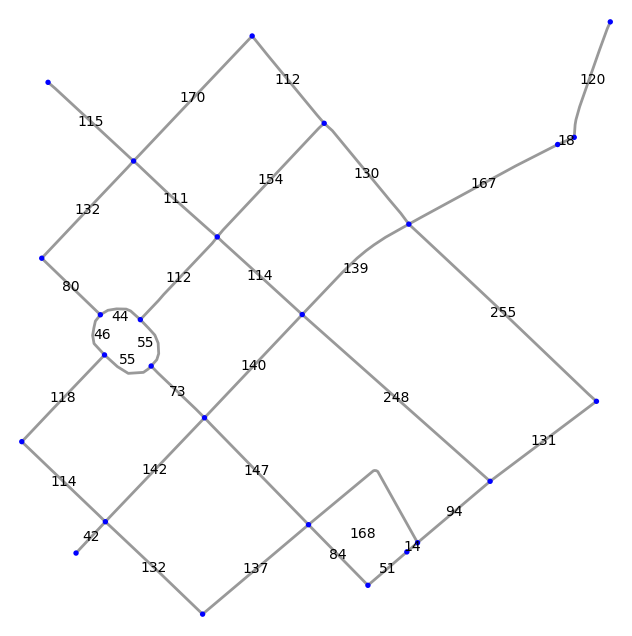

In [5]:
# Generate plot to verify that graph is suitable
generate_plot(graph)

In [6]:
# Given two nodes u and v from source_graph, copy the edge and its attributes to target_graph
# Update path_length, traversed_edges and solution_path
def copy_edge_to_solution(u, v, source_graph, target_graph, solution_path, traversed_edges, path_length):
    solution_path.append((u, v))
    traversed_edges.add((u, v))
    traversed_edges.add((v, u))

    path_length += source_graph[u][v][0]['length']

    data = source_graph[u][v][0]
    target_graph.add_edge(u, v, **data)

In [7]:
# Generate initial (likely unoptimal) feasible solution
def generate_initial_solution(graph):
    path_length = 0
    solution_path = []
    traversed_edges = set()

    # Configure solution graph
    solution_graph = nx.MultiDiGraph() # Directed graph
    solution_graph.graph['crs'] = graph.graph['crs']
    solution_graph.add_nodes_from(graph.nodes(data=True)) # Copy all nodes (without edges)

    # Start from a random vertex
    # TODO: choice could be optimized
    start_vertex = random.choice(list(graph.nodes))
    edge_count = graph.number_of_edges()

    # Keep track of path to backtrack our steps
    path = [start_vertex]

    # While there are nodes in path and while not all graph edges were traversed
    while path and len(traversed_edges) < 2 * edge_count:
        current_vertex = path[-1] # get the most recent node in path

        neighbor_vertices = list(graph.neighbors(current_vertex))
        unvisited_neighbors = [n for n in neighbor_vertices if (current_vertex, n) not in traversed_edges and (n, current_vertex) not in traversed_edges]

        if unvisited_neighbors:
            # Get neighbor with the smallest amount of neighbors
            sorted_neighbors = sorted(unvisited_neighbors, key=lambda x: len(list(graph.neighbors(x))))
            next_vertex = sorted_neighbors[0]

            # Add the edge to the solution graph
            copy_edge_to_solution(current_vertex, next_vertex, graph, solution_graph, solution_path, traversed_edges, path_length)

            # Debugging
            # fig, ax = ox.plot_graph(solution_graph, node_color='gray', edge_linewidth=2, bgcolor='white', show=True)

            path.append(next_vertex)
        else:
            path.pop()  # backtrack
            backstep_vertex = path[-1]

            if path:
                # Add the edge to the solution graph
                copy_edge_to_solution(current_vertex, backstep_vertex, graph, solution_graph, solution_path, traversed_edges, path_length)

    if solution_path[-1][1] != solution_path[1][0]:
        new_edges = dijkstra(graph, solution_path[-1][1], solution_path[0][0])
        for edge in new_edges:
                solution_path.append(edge)

    return solution_graph, solution_path, path_length

init_graph, init_path, init_length = generate_initial_solution(graph)
compare_graphs_by_connected_edges(graph, init_graph.to_undirected())

[OK] Graphs have identical connected edges


True

In [8]:
print('How the path looks:\n')
print(init_path)

How the path looks:

[(31200176, 26609164), (26609164, 29029083), (29029083, 26609164), (26609164, 26695890), (26695890, 26695910), (26695910, 26695895), (26695895, 27023894), (27023894, 27023892), (27023892, 26609130), (26609130, 27023892), (27023892, 27023891), (27023891, 26639009), (26639009, 26609129), (26609129, 26678576), (26678576, 678874676), (678874676, 5134398652), (5134398652, 678874676), (678874676, 26678576), (26678576, 26609129), (26609129, 27023890), (27023890, 26609175), (26609175, 31200174), (31200174, 409108466), (409108466, 26695911), (26695911, 31200173), (31200173, 31200176), (31200176, 31200173), (31200173, 31200174), (31200174, 31200173), (31200173, 26609136), (26609136, 26695897), (26695897, 26695900), (26695900, 26695895), (26695895, 26695900), (26695900, 34639066), (34639066, 26639009), (26639009, 34639066), (34639066, 26609133), (26609133, 26609175), (26609175, 26609133), (26609133, 26609129), (26609129, 26609133), (26609133, 26609136), (26609136, 26609164), 

In [9]:
from collections import defaultdict

class Solution:
    def __init__(self, graph, given_solution_graph, given_solution_path, edges_to_remove = 4):
        self.length = 0
        self.original_graph = graph
        self.edges_to_remove = edges_to_remove

        self.given_solution_graph = given_solution_graph
        self.given_solution_path = given_solution_path

        self.multiedges = self.get_multiedges()

        self.start_vertex, self.next_vertex = random.choice(self.multiedges) # Randomly choose a multiedge to remove

        # Final results are stored here
        self.path = [] # Re-traverse from the start_vertex
        self.graph = given_solution_graph.copy() # Creating a deep copy of the current solution graph to avoid modifying the original

        self.traversed_edges = set() # Keep track of traversed edges. When edge (u,v) is traversed, edge (v,u) is also added
        self.traversal_stack = [self.start_vertex] # While traversing randomly through graph, helps to trace the path back

        # Iterators
        self.current_vertex = self.traversal_stack[-1]
        self.unvisited_neighbors = [] # Unvisited neighbor vertices
        self.neighbor_vertices = [] # Current vertex neighbors

    # Since self.traversed_edges edges counted twice, final solution would be twice bigger than original graph
    def has_traversed_all_edges(self):
        return len(self.traversed_edges) < 2 * self.original_graph.number_of_edges()

    # Searhing for solution while traversal stack is not empty or all edges were traversed
    def search_in_progress(self):
        return self.traversal_stack and self.has_traversed_all_edges()

    def get_multiedges(self):
        edge_counts = defaultdict(int) # set default value of 0 for undefined edges

        # Count the occurrences of each edge (both directions)
        for edge in self.given_solution_path:
            edge_counts[edge] += 1
            reverse_edge = (edge[1], edge[0])
            edge_counts[reverse_edge] += 1

        # Filter out edges that occur more than once
        return [edge for edge, count in edge_counts.items() if count > 1]

    def remove_random_edges(self):
        start_vertex = self.start_vertex
        next_vertex = self.next_vertex

        # Remove the edges between two vertices
        if self.graph.has_edge(start_vertex, next_vertex):
            keys = list(self.graph[start_vertex][next_vertex].keys())
            self.graph.remove_edge(start_vertex, next_vertex, key=keys[0])

        # Remove some subsequent edges
        for _ in range(self.edges_to_remove):
            if self.graph.out_degree(next_vertex) > 0:
                successor = random.choice(list(self.graph.successors(next_vertex)))
                if self.graph.has_edge(next_vertex, successor):
                    keys = list(self.graph[next_vertex][successor].keys())
                    self.graph.remove_edge(next_vertex, successor, key=keys[0])
                    self.traversed_edges.discard((next_vertex, successor))
                    next_vertex = successor

    def get_neighbor_vertices(self):
        return list(self.original_graph.neighbors(self.current_vertex))

    def set_unvisited_neighbors(self):
        self.neighbor_vertices = self.get_neighbor_vertices()
        self.unvisited_neighbors =  [n for n in self.neighbor_vertices if (self.current_vertex, n) not in self.traversed_edges and (n, self.current_vertex) not in self.traversed_edges]

    def set_random_next_vertex(self):
        # Prioritize unvisited neighbors
        if self.unvisited_neighbors:
            self.next_vertex = random.choice(self.unvisited_neighbors)
        else:
            self.next_vertex = random.choice(self.neighbor_vertices)

    def add_edge_to_solution(self, u, v):
        self.path.append((u, v))
        self.traversed_edges.add((u, v))
        self.traversed_edges.add((v, u))

        data = self.original_graph[u][v][0]

        self.length += data['length']
        self.graph.add_edge(u, v, **data)

    def get_last_stack_item(self):
        return self.traversal_stack[-1]

    def close_cycle(self):
        if self.path[0][0] != self.path[-1][1]:
            new_edges = dijkstra(self.original_graph, self.path[-1][1], self.path[0][0])
            for edge in new_edges:
                self.path.append(edge)

def get_neighbors(graph, solution_graph, solution_path, num_neighbors=5, edges_to_remove=4):
    """
    Generate neighboring solutions by re-traversing multiedges and their subsequent edges.
    """
    neighbor_solutions = []

    for _ in range(num_neighbors):
        solution = Solution(graph, solution_graph, solution_path, edges_to_remove)
        multiedges = solution.multiedges

        if not multiedges:
            break

        solution.remove_random_edges()

        while solution.search_in_progress():
            solution.set_unvisited_neighbors()
            solution.set_random_next_vertex()

            if solution.unvisited_neighbors:
                solution.add_edge_to_solution(solution.current_vertex, solution.next_vertex)
                solution.traversal_stack.append(solution.next_vertex)

                solution.current_vertex = solution.next_vertex
            else:
                solution.traversal_stack.pop()

                if solution.traversal_stack:
                    backstep_vertex = solution.get_last_stack_item()
                    solution.add_edge_to_solution(solution.current_vertex, backstep_vertex)
                    solution.current_vertex = backstep_vertex

        solution.close_cycle()

        neighbor_solutions.append(solution)

    return neighbor_solutions

# Adjust the tabu_search function slightly
def tabu_search(init_graph, init_path):
    global graph

    current_graph = best_graph = init_graph
    current_path = best_path = init_path
    best_path_length = evaluate(best_path)
    tabu_path_list = []

    MAX_ITERATIONS = 1000
    TABU_LIST_SIZE = 150

    # We remove edges (starting from random multi-edge, i.e., edge with multiple traversals)
    # And then increase the number of edges removed in hope to find a better solution
    iterations_since_best_solution = 0
    total_iterations_since_best_solution = 0
    edges_to_remove = 4

    for iteration in range(MAX_ITERATIONS):
        neighbors = get_neighbors(graph, current_graph, current_path, 5, edges_to_remove)
        iterations_since_best_solution += 1
        total_iterations_since_best_solution += 1

        # Filter out neighbors that are in the tabu list, but include better ones than the global best
        viable_neighbors = [s for s in neighbors if s.path not in tabu_path_list or evaluate(s.path) < best_path_length]

        if not viable_neighbors:
            break

        next_solution = min(viable_neighbors, key=lambda x: evaluate(x.path))
        next_graph = next_solution.graph
        next_path = next_solution.path
        next_path_length = evaluate(next_path)

        # Update the best solution
        if next_path_length < best_path_length:
            best_graph = next_graph
            best_path = next_path
            best_path_length = next_path_length

            iterations_since_best_solution = 0
            total_iterations_since_best_solution = 0
            print(f'[Epoch {iteration}] New best solution length: {best_path_length}')

        # Update tabu list
        tabu_path_list.append(next_path)
        tabu_path_list = tabu_path_list[-TABU_LIST_SIZE:]  # Ensure that tabu_list doesn't exceed the size

        current_graph = next_graph
        current_path = next_path

        # After X failed iterations to find a better solution than the best one
        # Increase the number of edges to remove
        if iterations_since_best_solution >= 100:
            iterations_since_best_solution = 0
            edges_to_remove += 1

            # Exit if the number of edges removed is bigger than 1/3 of original graph edges
            # Or 300 unsuccessful iterations happened
            if edges_to_remove > graph.number_of_edges()/3 or total_iterations_since_best_solution > 300:
                print(f'[!Stopping criteria detected!] Exiting algorithm')
                break

            print(f'[!Stagnation detected!] Number of edges to remove: {edges_to_remove}')

        if iteration % 100 == 0:
            print(f'---New epoch: {iteration}---')

    return best_graph, best_path

def evaluate(solution_path):
    global graph

    distance = 0

    for u, v in solution_path:
        distance += round(graph[u][v][0]['length'])

    return distance

Initial solution length: 6354


/home/daniels/PycharmProjects/pko_md1/venv/lib/python3.11/site-packages/osmnx/plot.py:309: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, s=orig_dest_size, c=route_color, alpha=route_alpha, edgecolor="none")


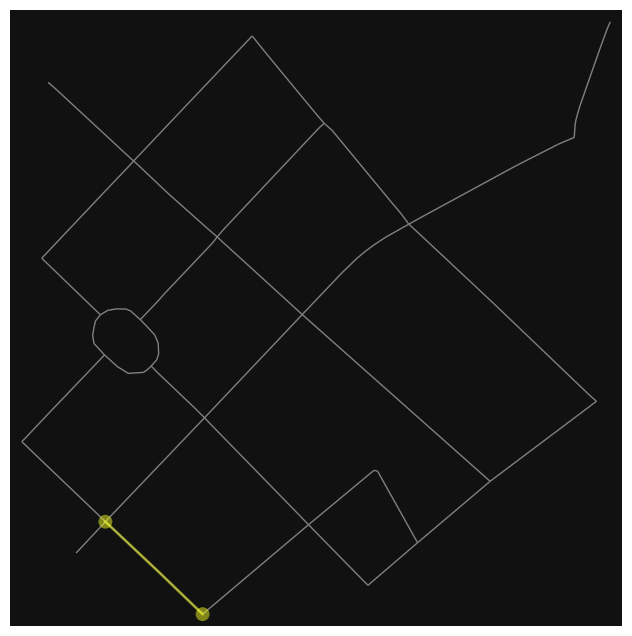

In [10]:
print(f'Initial solution length: {evaluate(init_path)}')
animate_graph_traversal(graph, init_path, 'init.gif') # Creates a visualization of the solution

[Epoch 0] New best solution length: 5851
---New epoch: 0---
[Epoch 7] New best solution length: 5516
[Epoch 15] New best solution length: 5481
[Epoch 29] New best solution length: 5350
[Epoch 61] New best solution length: 5305
---New epoch: 100---
[Epoch 136] New best solution length: 5134
---New epoch: 200---
[!Stagnation detected!] Number of edges to remove: 5
---New epoch: 300---
[!Stagnation detected!] Number of edges to remove: 6
---New epoch: 400---
[!Stagnation detected!] Number of edges to remove: 7
---New epoch: 500---
[!Stopping criteria detected!] Exiting algorithm
Elapsed time: 82.6599485874176 seconds
Best found solution length: 5134 meters


/home/daniels/PycharmProjects/pko_md1/venv/lib/python3.11/site-packages/osmnx/plot.py:309: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, s=orig_dest_size, c=route_color, alpha=route_alpha, edgecolor="none")


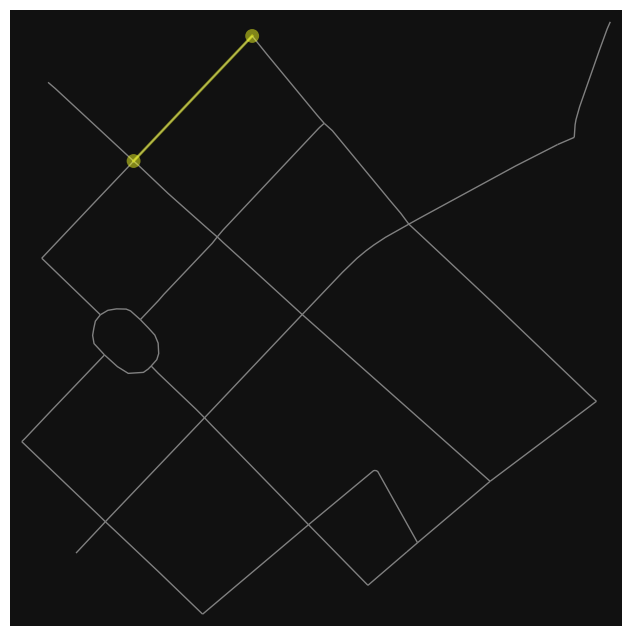

In [11]:
import time
start = time.time()
best_graph, best_path = tabu_search(init_graph, init_path)
end = time.time()
print(f'Elapsed time: {end-start} seconds')
print(f'Best found solution length: {evaluate(best_path)} meters')
animate_graph_traversal(graph, best_path, 'best.gif')